In [ ]:
# Module 04 — Inference & Annotation
Tasks:
1. Load trained classifier checkpoint.
2. Run template/test subtraction to obtain defect masks.
3. Extract ROIs and classify each ROI.
4. Annotate test images with labeled bounding boxes.
5. Save per-image CSV detections and a batch summary CSV.

Notes:
- Ensure Module 03 produced a checkpoint under `checkpoints/` (e.g. best_effnet_b0_cpu_ultrafast.pth or best_effnet_b0_cpu.pth).
- IMG_SIZE used here should match the model training IMG_SIZE (default 224).


In [1]:
# Step 4.1 — imports, device & paths
from pathlib import Path
import json, time
import cv2, numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# dataset root (adjust if necessary)
DATASET_ROOT = Path(r"C:\Users\Lavanya R\Downloads\PCB_DATASET\PCB_DATASET")
IMAGES_ROOT = DATASET_ROOT / "images"
ROTATION_ROOT = DATASET_ROOT / "rotation"

ROIS_DIR = Path("data/rois/images")
TRAIN_CSV = Path("data/rois/train_labels.csv")
CKPT_DIR = Path("checkpoints")
OUT_DIR = Path("inference_results"); OUT_DIR.mkdir(exist_ok=True, parents=True)

# find candidate checkpoint(s)
ckpt_candidates = list(CKPT_DIR.glob("*ultrafast*.pth")) + list(CKPT_DIR.glob("best_effnet_b0*.pth")) + list(CKPT_DIR.glob("*.pth"))
print("Checkpoints found:", [p.name for p in ckpt_candidates])


Device: cpu
Checkpoints found: ['best_effnet_b0_cpu_ultrafast.pth', 'best_effnet_b0_cpu.pth', 'best_effnet_b0_cpu_ultrafast.pth', 'best_effnet_b0_cpu.pth', 'best_effnet_b0_cpu_ultrafast.pth']


In [2]:
# Step 4.2 — load checkpoint and model
import timm, torch.nn as nn

if len(ckpt_candidates) == 0:
    raise FileNotFoundError("No checkpoint found in checkpoints/. Run Module 03 first.")

ckpt_path = ckpt_candidates[0]
ckpt = torch.load(ckpt_path, map_location=device)

label2idx = ckpt.get("label2idx", None)
if label2idx is None:
    # try reading from train csv if checkpoint lacks it
    if TRAIN_CSV.exists():
        tmp = pd.read_csv(TRAIN_CSV)
        labs = sorted(tmp['label'].unique())
        label2idx = {lab:i for i,lab in enumerate(labs)}
    else:
        raise RuntimeError("label2idx missing in checkpoint and train CSV not found.")
idx2label = {int(v):k for k,v in label2idx.items()}
num_classes = len(idx2label)
print("Loaded checkpoint:", ckpt_path.name, "num_classes:", num_classes)

# build EfficientNet-B0 (matches CPU-friendly training)
model = timm.create_model("efficientnet_b0", pretrained=False, num_classes=num_classes)
model.load_state_dict(ckpt["model_state"])
model = model.to(device)
model.eval()
print("Model loaded and ready.")


C:\Users\Lavanya R\.conda\envs\circuitguard\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded checkpoint: best_effnet_b0_cpu_ultrafast.pth num_classes: 6
Model loaded and ready.


In [3]:
# Step 4.3 — preprocess + ROI helpers (same algorithm as Module 1/2)
def preprocess_and_subtract_paths(template_path, test_path, resize_to=(1024,1024)):
    t = cv2.imread(str(template_path), cv2.IMREAD_GRAYSCALE)
    s = cv2.imread(str(test_path), cv2.IMREAD_GRAYSCALE)
    if t is None or s is None:
        raise ValueError(f"Cannot read images: {template_path}, {test_path}")
    if resize_to:
        t = cv2.resize(t, resize_to)
        s = cv2.resize(s, resize_to)
    diff = cv2.absdiff(s, t)
    diff_blur = cv2.GaussianBlur(diff, (5,5), 0)
    _, th = cv2.threshold(diff_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=2)
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=1)
    return diff, th

def extract_rois_from_mask(test_img_path, mask, min_area=80, pad=6, max_rois=None):
    img_bgr = cv2.imread(str(test_img_path))
    if img_bgr is None:
        raise ValueError(f"Cannot read test image: {test_img_path}")
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    rois = []
    for i, cnt in enumerate(contours):
        if max_rois is not None and i >= max_rois:
            break
        area = cv2.contourArea(cnt)
        if area < min_area:
            continue
        x,y,w,h = cv2.boundingRect(cnt)
        x0 = max(0, x-pad); y0 = max(0, y-pad)
        x1 = min(img_bgr.shape[1], x+w+pad); y1 = min(img_bgr.shape[0], y+h+pad)
        crop = img_bgr[y0:y1, x0:x1]
        rois.append(((x0,y0,x1,y1), crop))
    return rois


In [4]:
# Step 4.4 — transform a BGR crop -> tensor that the model expects
import torchvision.transforms as T
IMG_SIZE = ckpt.get("img_size", 224) or 224
val_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

def crop_to_tensor(crop_bgr):
    # crop_bgr: OpenCV BGR ndarray -> PIL RGB -> transformed tensor (1,C,H,W)
    img_rgb = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB)
    pil = Image.fromarray(img_rgb)
    t = val_transform(pil).unsqueeze(0)
    return t


In [5]:
# Step 4.5 — run inference on one template/test pair (selected_paths.json or auto pick)
sel_path = Path("selected_paths.json")
if sel_path.exists():
    sel = json.loads(sel_path.read_text())
    template_path = Path(sel["template"]); test_path = Path(sel["test"])
    print("Using selected_paths.json:", template_path.name, test_path.name)
else:
    # fallback auto-pick: first class first pair
    cls = sorted([d.name for d in IMAGES_ROOT.iterdir() if d.is_dir()])[0]
    template_path = sorted((IMAGES_ROOT/cls).glob("*"))[0]
    test_path = sorted((ROTATION_ROOT/f"{cls}_rotation").glob("*"))[0]
    print("Auto-picked:", template_path.name, test_path.name)

# compute mask and rois
diff, mask = preprocess_and_subtract_paths(template_path, test_path, resize_to=(1024,1024))
rois = extract_rois_from_mask(test_path, mask, min_area=80, pad=6, max_rois=50)
print("ROIs extracted:", len(rois))

# classify ROIs
detections = []
for i, (bbox, crop) in enumerate(rois):
    tensor = crop_to_tensor(crop).to(device)
    with torch.no_grad():
        logits = model(tensor)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]
    top_idx = int(probs.argmax())
    score = float(probs[top_idx])
    label = idx2label.get(top_idx, str(top_idx))
    detections.append({"roi_idx": i, "bbox": bbox, "label": label, "score": score})
print("Detections count:", len(detections))


Using selected_paths.json: 01_missing_hole_01.jpg 01_missing_hole_01.jpg
ROIs extracted: 50
Detections count: 50


Annotated image saved to: inference_results\annotated_01_missing_hole_01.png


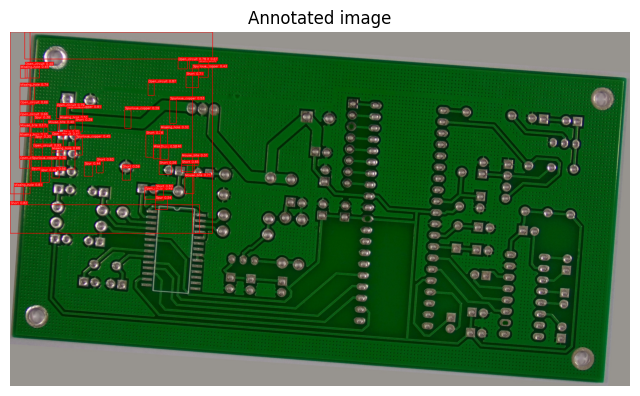

In [6]:
# Step 4.6 — draw bounding boxes & labels on original test image (resized coords)
test_img_bgr = cv2.imread(str(test_path))
annot = test_img_bgr.copy()

for d in detections:
    x0,y0,x1,y1 = d["bbox"]
    lbl = f"{d['label']} {d['score']:.2f}"
    color = (0,0,255)  # red
    cv2.rectangle(annot, (x0,y0), (x1,y1), color, 2)
    ((tw, th), _) = cv2.getTextSize(lbl, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    # label background
    cv2.rectangle(annot, (x0, y0 - th - 6), (x0 + tw + 4, y0), color, -1)
    cv2.putText(annot, lbl, (x0+2, y0-4), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

out_img_path = OUT_DIR / f"annotated_{test_path.stem}.png"
cv2.imwrite(str(out_img_path), annot)
print("Annotated image saved to:", out_img_path)

# show inline
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(annot, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.title("Annotated image")
plt.show()


In [7]:
# Step 4.7 — save detections for this test image
out_csv = OUT_DIR / f"detections_{test_path.stem}.csv"
rows = []
for d in detections:
    x0,y0,x1,y1 = d["bbox"]
    rows.append({
        "image": test_path.name,
        "roi_idx": d["roi_idx"],
        "x0": x0, "y0": y0, "x1": x1, "y1": y1,
        "label": d["label"], "score": d["score"]
    })
pd.DataFrame(rows).to_csv(out_csv, index=False)
print("Detections CSV saved to:", out_csv)


Detections CSV saved to: inference_results\detections_01_missing_hole_01.csv


In [ ]:
# === FAST Step 4.8 — Batch Inference for All Classes (CPU-Optimized) ===
import time

summary_fast = []
start_time = time.time()

classes = sorted([d.name for d in IMAGES_ROOT.iterdir() if d.is_dir()])
print("Classes detected:", classes)

for cls in classes:
    print(f"\nProcessing class: {cls}")
    src_dir = IMAGES_ROOT / cls
    rot_dir = ROTATION_ROOT / f"{cls}_rotation"
    
    if not src_dir.exists() or not rot_dir.exists():
        print(f"  Skipped (missing folder): {cls}")
        continue

    # all template images
    templates = sorted([p for p in src_dir.glob("*") if p.suffix.lower() in ['.jpg', '.jpeg', '.png']])

    for tpath in templates:
        test_path = rot_dir / tpath.name
        if not test_path.exists():
            continue

        # 1. FAST preprocessing (smaller size)
        diff, mask = preprocess_and_subtract_paths(tpath, test_path, resize_to=(800, 800))

        # Quickly skip if no defects detected
        if cv2.countNonZero(mask) < 10:
            summary_fast.append({
                "test_image": test_path.name,
                "roi_idx": None,
                "x0": None, "y0": None, "x1": None, "y1": None,
                "label": "No Defect",
                "score": 1.0
            })
            continue

        # 2. ROI extraction (MAX 10 — very fast)
        rois = extract_rois_from_mask(test_path, mask, min_area=80, pad=6, max_rois=10)

        # 3. Classify each ROI
        for i, (bbox, crop) in enumerate(rois):
            tensor = crop_to_tensor(crop).to(device)
            with torch.no_grad():
                logits = model(tensor)
                probs = torch.softmax(logits, dim=1)[0].cpu().numpy()

            top_idx = int(probs.argmax())
            score = float(probs[top_idx])
            label = idx2label[top_idx]

            summary_fast.append({
                "test_image": test_path.name,
                "roi_idx": i,
                "x0": bbox[0], "y0": bbox[1],
                "x1": bbox[2], "y1": bbox[3],
                "label": label,
                "score": score
            })

# Save summary
fast_out = OUT_DIR / "batch_detections_summary_FAST.csv"
pd.DataFrame(summary_fast).to_csv(fast_out, index=False)

print("\n=== FAST Batch Inference Completed ===")
print("Total images processed:", len(summary_fast))
print("Saved to:", fast_out)

elapsed = time.time() - start_time
print(f"Total time: {elapsed/60:.2f} minutes (CPU-optimized)")


Classes detected: ['Missing_hole', 'Mouse_bite', 'Open_circuit', 'Short', 'Spur', 'Spurious_copper']

Processing class: Missing_hole
